In [1]:
def hama_response(N):
    filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--00000.dat'
    time,h = np.loadtxt(filename,unpack=True)
    ids = np.random.randint(1,300,size=(N-1,1))
    for id in ids:
        filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--%05i.dat' % id
        time,hi = np.loadtxt(filename,unpack=True)
        h = np.row_stack((h,hi))
    return time,h

In [2]:
def sample_distribution(axis,pde,N):
    #this function takes in a sampling axis and a corresponding distribution and produce indices of N samples. 
    fig = plt.figure()
    plt.plot(axis,pde)
    plt.grid(True)
    plt.title('PDE')
    
    ids=np.empty([0])
    while ids.size!=N:
        for i in range(len(pde)):
            if np.random.choice([1,0], p=[pde[i],1-pde[i]]) == 1:
                ids = np.append(ids,i)
                ids = np.unique(ids)
                break
    ids = ids.astype(int)
    ids = np.resize(ids,(N,1))
    return axis[ids]

In [3]:
def generate_sparse_convolmatrix(havg):
    hsparse = sparse.lil_matrix((havg.size,havg.size))
    for i in range(havg.size-1):
        hsparse[i,:(i+1)]=havg[i+1:0:-1]
    return hsparse

<IPython.core.display.Javascript object>


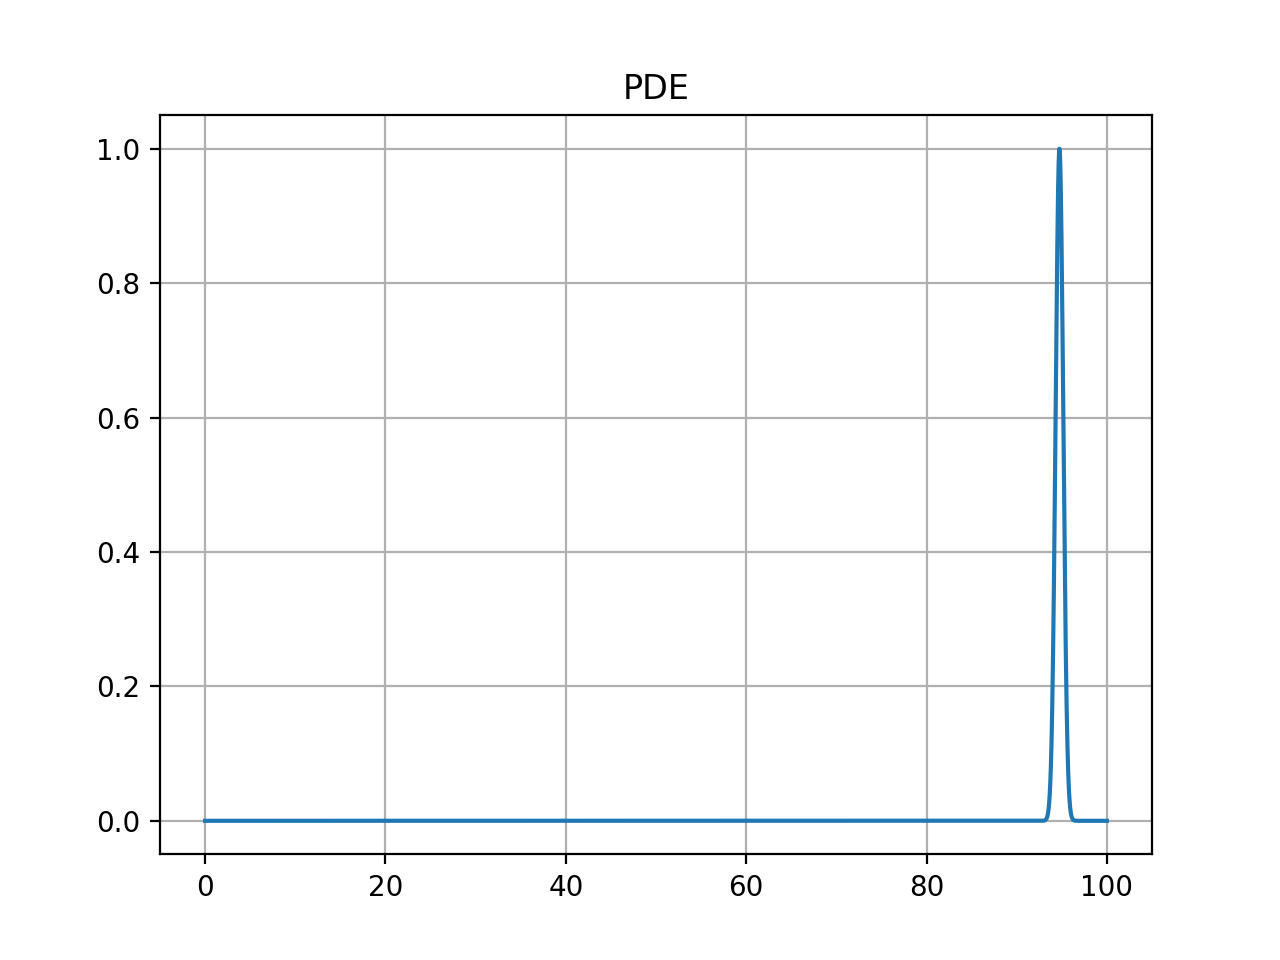

[[ 76.35192835]
 [ 76.29880827]
 [ 76.28656553]
 [ 76.25802203]
 [ 76.24172584]
 [ 76.22951055]
 [ 76.21730114]
 [ 76.21323263]
 [ 76.20509758]
 [ 76.19696513]
 [ 76.1766454 ]
 [ 76.16852206]
 [ 76.16446136]
 [ 76.14822506]
 [ 76.12794429]]


<IPython.core.display.Javascript object>


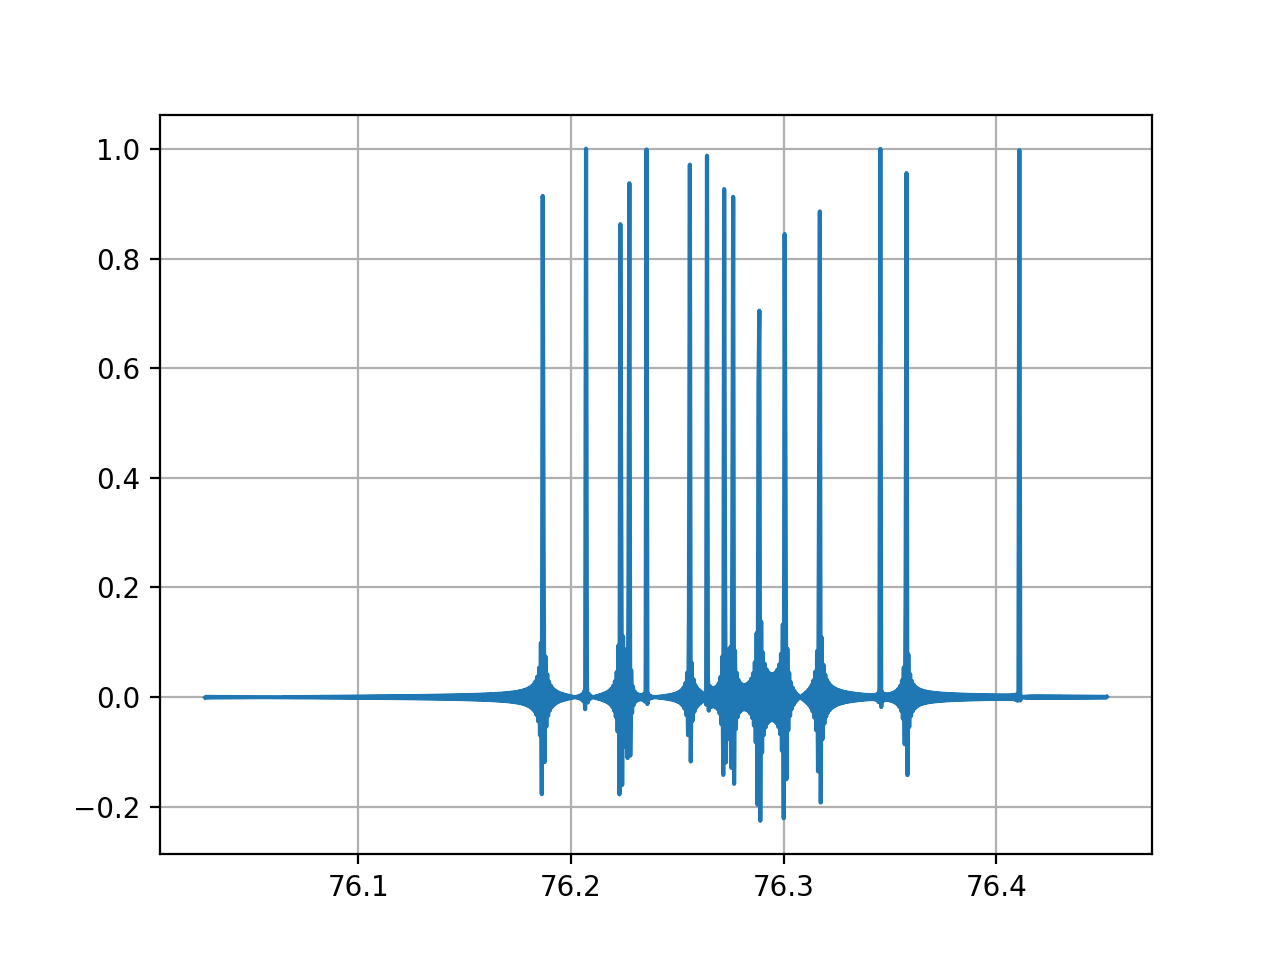

In [12]:
%matplotlib notebook

"""Target in this cell is to sample energies according to an energy distribution with the change in central energy.
Also get the time corresponding time of arrivals(TOAs)."""

from buildwaveforms import energy2time
import numpy as np
from scipy.fftpack import fft, fftfreq, ifft
import matplotlib.pyplot as plt

E0i = 0  #eV
E0f = 100 #eV
delta_E0i = 1.0e-4 #ev
delta_E0f = 0.4 #eV
N_E0_pts = 20  # no. of distributions with different E0s(central energies)

E0 = np.linspace(E0i,E0f,N_E0_pts)
delta_E = ((delta_E0f-delta_E0i)/E0f**2)*E0**2  # ~quadratic fit(may be a source of numerical error)

#define the energy axis and energy distribution
Ei = 0  #eV
Ef = 100 #eV
N_E_pts = 10000
E = np.linspace(Ei,Ef,N_E_pts)
E_dist = np.exp(-(E-E0[-2])**2/delta_E[-2])
#E_dist = np.exp(-(E-E0[5])**2/50)

N_E_sam = 15
E_rand = sample_distribution(E,E_dist,N=N_E_sam)
time_TOA = energy2time(E_rand)
print time_TOA

timeaxis_TOA = np.linspace(min(time_TOA)-0.1,max(time_TOA)+0.1,1000)
freq_TOA = fftfreq(timeaxis_TOA.size,d = timeaxis_TOA[1]-timeaxis_TOA[0])
s_TOA = np.real(ifft(np.sum(np.exp(-2*np.pi*1j*freq_TOA*time_TOA),axis=0)))

fig = plt.figure()
plt.plot(timeaxis_TOA,s_TOA)
plt.grid(True)

Time elapsed= 1053 ms


<IPython.core.display.Javascript object>


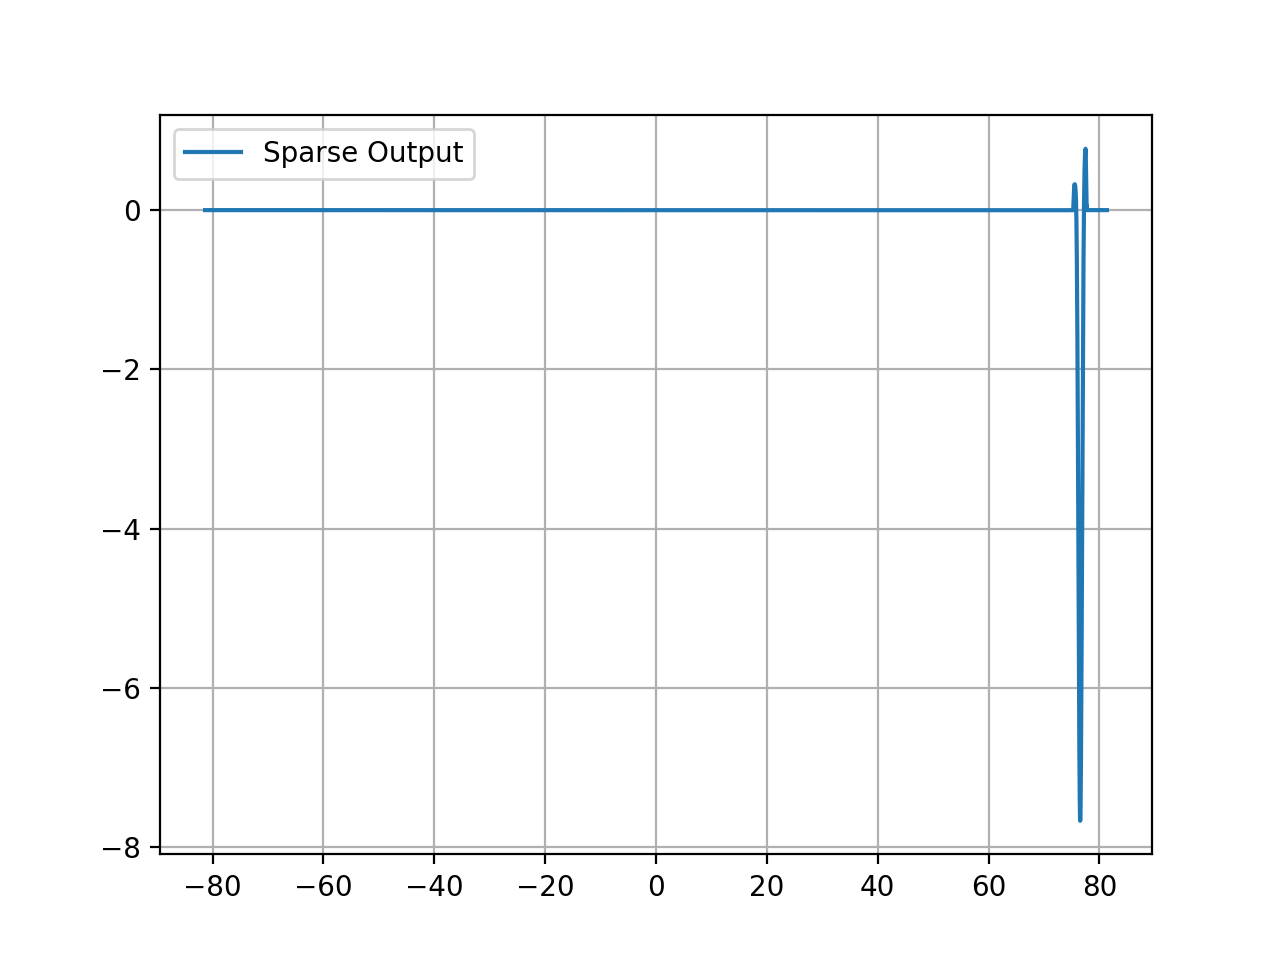

In [13]:
%matplotlib notebook

import numpy as np
from scipy.fftpack import fft, fftfreq, ifft
from scipy.signal import hilbert
from scipy import sparse
import matplotlib.pyplot as plt
import time

timeaxis, h = hama_response(N_E_sam)
havg = np.mean(h,axis=0)
Havg = fft(havg)

#rescale timeaxis and havg
rescale_pts = int(((2*(max(time_TOA)+5)*1e-9)/(timeaxis[-1]-timeaxis[0]))*timeaxis.size)
timeaxis_new = np.linspace(-(max(time_TOA)+5)*1e-9,(max(time_TOA)+5)*1e-9,rescale_pts)

nzeros = np.zeros((rescale_pts-timeaxis.size)/2)
havg = np.append(havg,nzeros)
havg = np.insert(havg,0,nzeros)
if N_E_sam%2 ==1:
    havg = np.append(havg,0)
    
thr = []
frac =0.05
havg_im = np.imag(hilbert(havg))
snr = np.abs(havg)**2+np.abs(havg_im)**2
for i in range(havg.size):
    thr.append(frac*max(snr))

havg_mod = np.zeros(havg.size)
for i in range(havg.size):
    if snr[i]>=thr[0]:
        havg_mod[i] = havg[i]

#generate sparse convolution matrix
start = time.time()

hsparse = generate_sparse_convolmatrix(havg_mod)

freq = fftfreq(timeaxis_new.size,d = (timeaxis_new[1]-timeaxis_new[0]))
s = np.real(ifft(np.sum(np.exp(-2*np.pi*1j*freq*time_TOA*1e-9),axis=0)))

s_cpy = sparse.lil_matrix((1,s.size))
s_cpy[:] = s[:]
y_mod = (hsparse.tocsr()*s_cpy.tocsr().transpose())

end = time.time()
print 'Time elapsed= %i ms'%((end - start)*1000)

fig = plt.figure()
#plt.plot(timeaxis_new*1e9,s,label='Input Signal')
plt.plot(timeaxis_new*1e9,y_mod.todense(),label='Sparse Output')
plt.grid(True)
plt.legend()

In [6]:
hsparse.shape

(6519, 6519)

In [7]:
s.size

6518

In [10]:
(nzeros.size*)

2516